<a href="https://colab.research.google.com/github/JonCrook/icl-ml-portfolio/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

**Context:**\
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content:**\
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.\
It contains only numerical input variables which are the result of a Principle Component Analysis transformation (dimensionality reduction technique).\
Due to confidentiality issues, the original features and more background information about the data cannot be provided.
Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

> - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The model will be a Random Forest Classifier As this is a classification problem well suited to this approach. Bayesian Optimisation will be used to tune the model's hyperparameters

# 2. SetUp


## 2.1 Import Libraries

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from timeit import default_timer as timer
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

random_state = 11

## 2.2 Import Data

In [80]:
# Mount Google drive as using colab - change if loading from different location
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ColabData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
df = pd.read_csv(file_path + "creditcard.csv")
# Check what the data looks like
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 3. Data Analysis

## 3.1 Data Exploration

In [82]:
# Number of Rows & Columns
df.shape

(284807, 31)

In [83]:
# Column Names and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [84]:
# Basic Stats
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 3.2 Missing Values

In [85]:
# Check for columns with NaN values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [86]:
# See how many rows have a NaN
df[df.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


In [87]:
# none so no need to drop any rows
#df = df.dropna()
#df = df.reset_index(drop=True)
#df.shape

## 3.3 Target Class Imbalance

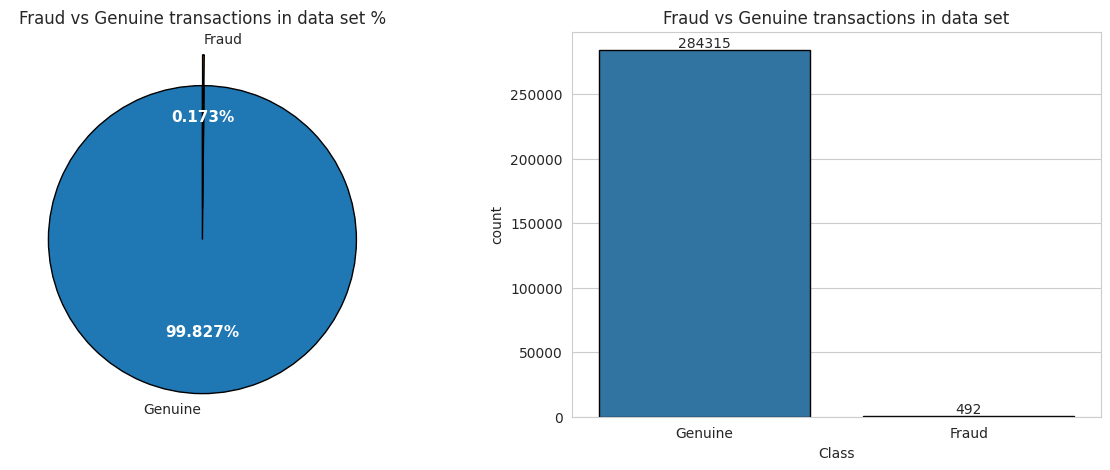

In [88]:
# Show the imbalance in the target variable 'Class'

class_counts = list(df['Class'].value_counts())
pie_values = [class_counts[0] / sum(class_counts) * 100, class_counts[1] / sum(class_counts) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
_, _, autopcts = plt.pie(pie_values,labels = ['Genuine','Fraud'], 
        autopct = '%1.3f%%',
        startangle = 90,
        explode = (0.1,0.1),
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in data set %');

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':11})

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='Class', 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
    
plt.title('Fraud vs Genuine transactions in data set')
plt.show()
plt.close()

## 3.4 Feature Correlation

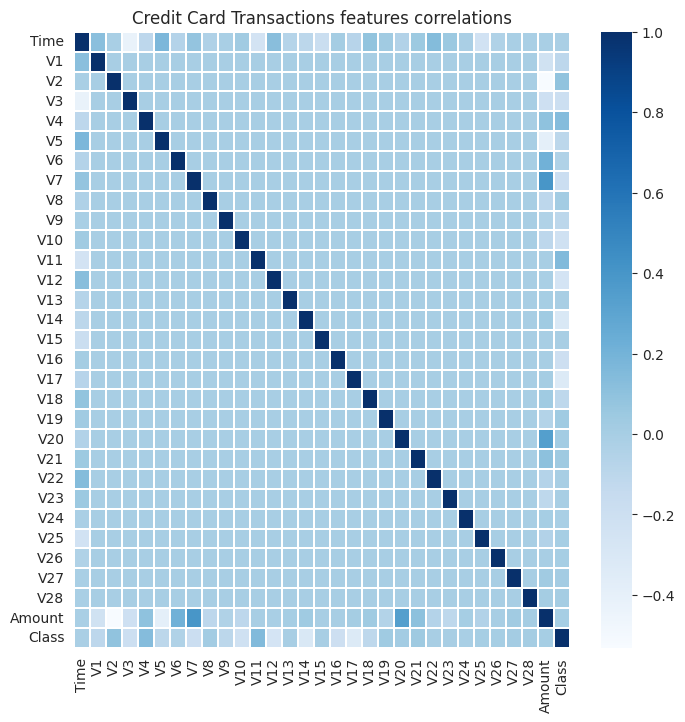

In [89]:
# Use a heatmap to show the correlation between the input variables
plt.figure(figsize = (8,8))
plt.title('Credit Card Transactions features correlations')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="coolwarm_r")
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

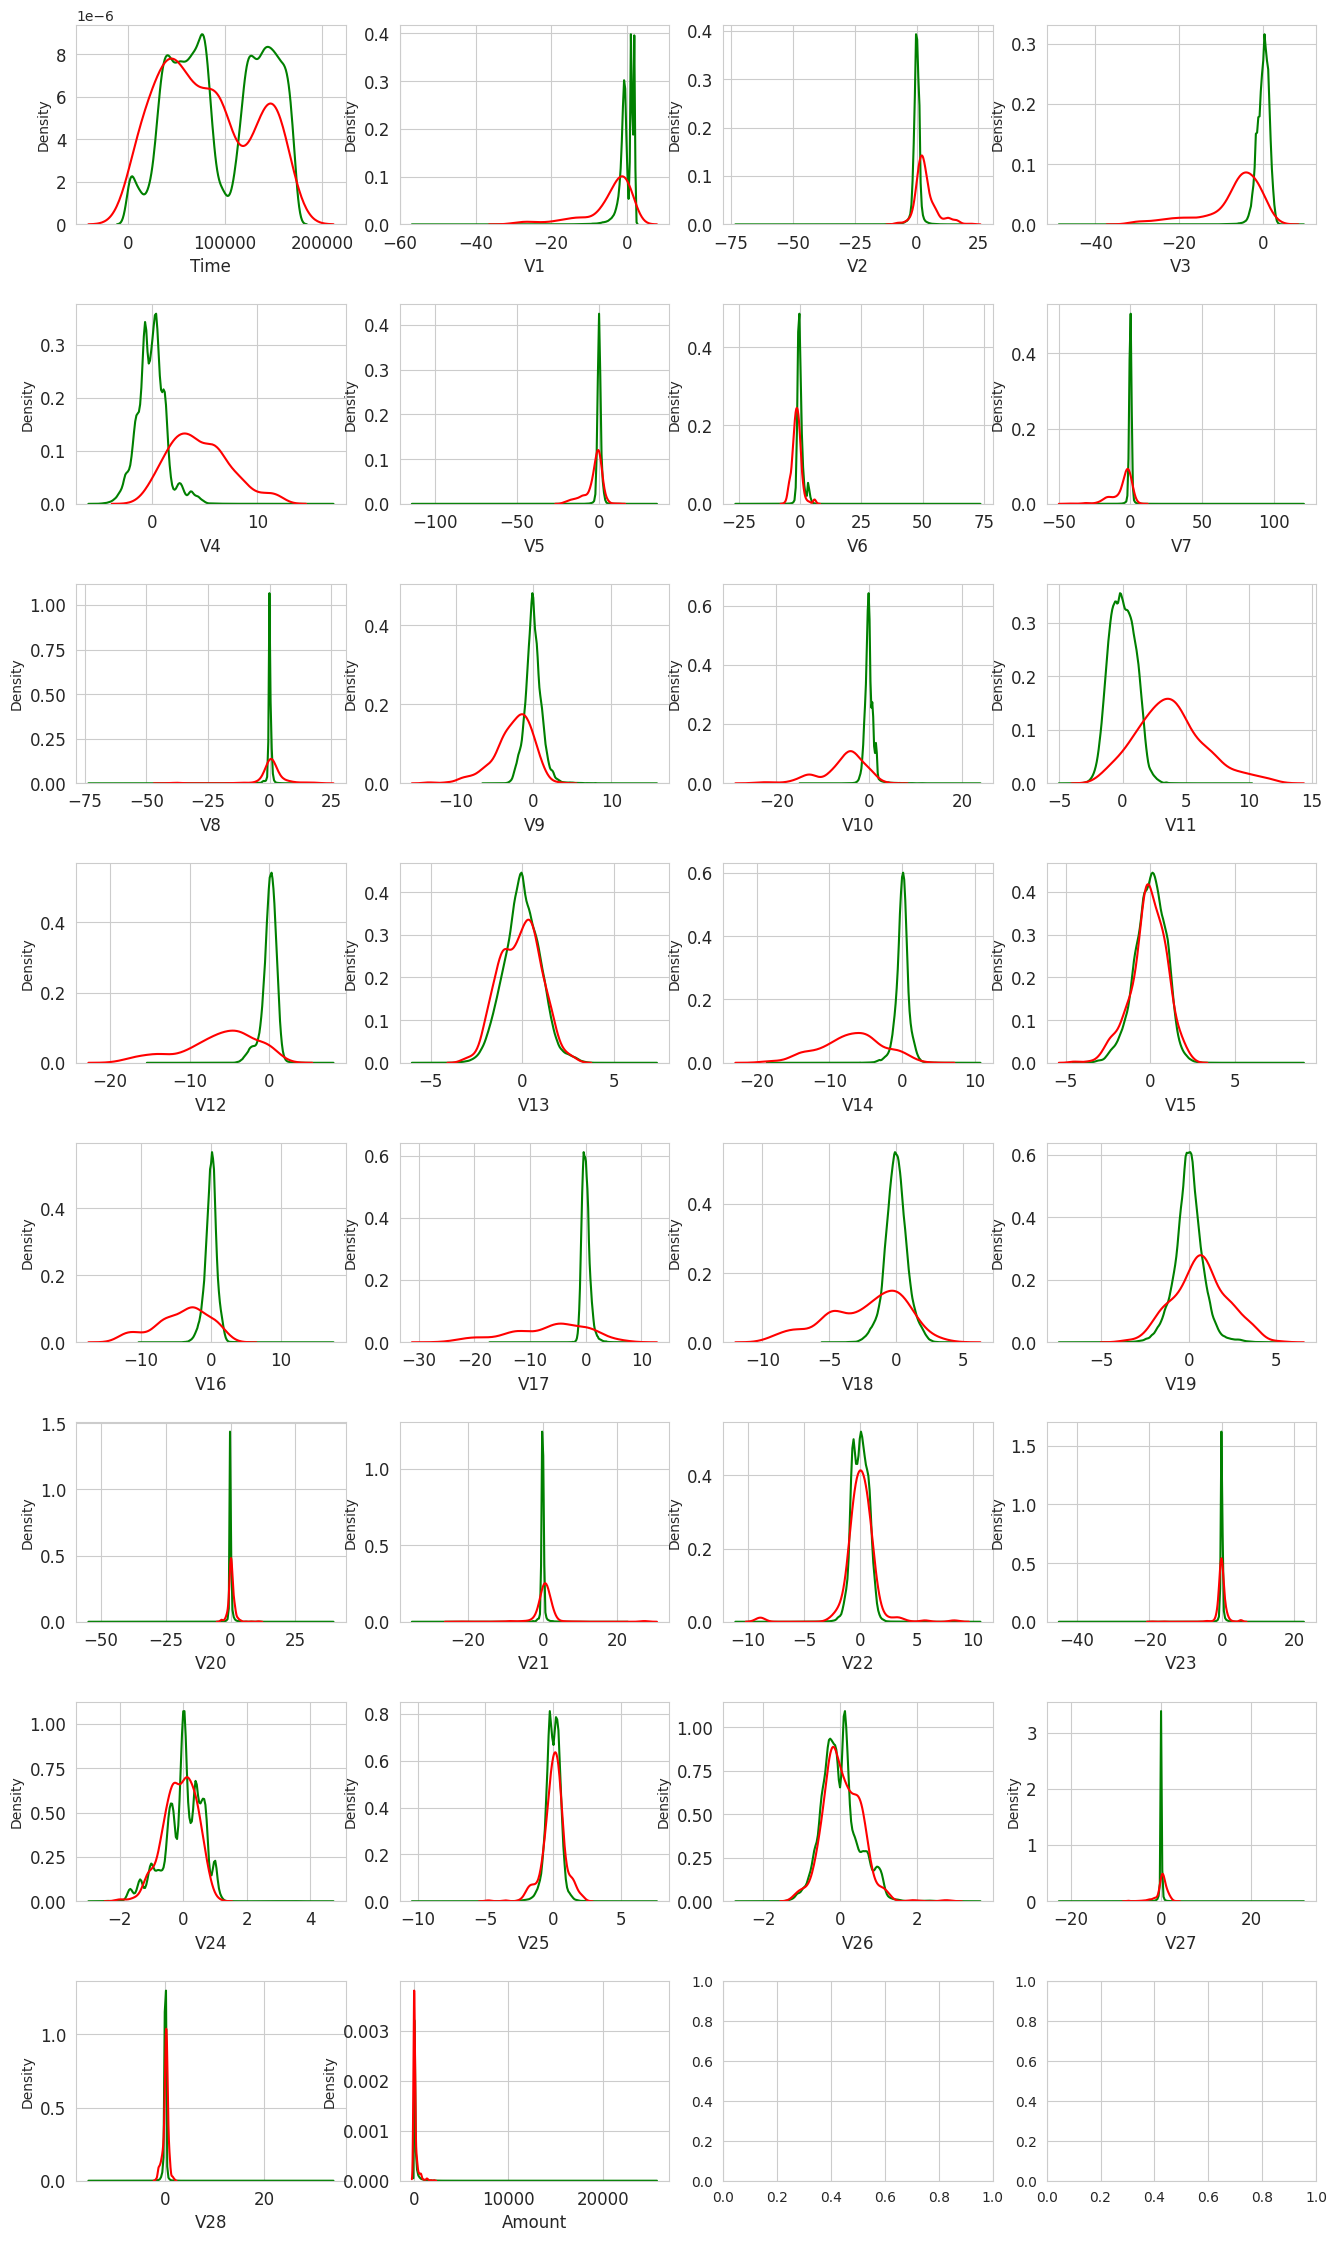

In [90]:
# Look at how each feature's distribution compares between fraud and genuine transactions
# Interested in features where the distributions diverge as this likely indicates a correlation 

# Remove the 'Class' feature as not plotting this
cols = np.delete(df.columns.values, np.where(df.columns.values == 'Class'))
i = 0
genuine = df.loc[df['Class'] == 0]
frauds = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))
plt.subplots_adjust(hspace = 0.4)

for feature in cols:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(genuine[feature],label="0", color='green')
    sns.kdeplot(frauds[feature],label="1", color='red')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();
plt.close()

A number of features show clear separation of distributions for the Class values 0 and 1. Those that are very similar and therefore have little impact on the class distinction could be dropped from the data to help simplify the model. Examples where the distribution are very similar and could be discounted are: 
* V8,  V13,  V15,  V20,  V22,  V23,  V24,  V25,  V26,  V28,  Amount



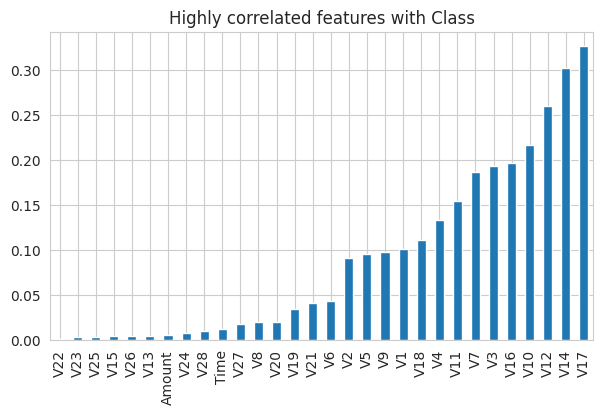

In [91]:
# Another way to look at correlation is with the panda.dataframe.corr() method
plt.figure(figsize=(7,4))
d = df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar',
                    title='Highly correlated features with Class')

The low correlation features match the info from the distribution curves

# 4. Train, Validation, Test Sets

In [92]:
def build_test_datasets(data, validation_size=0.25, test_size=0.20):
  X = data.drop('Class', axis=1)
  y = data['Class']
  
  # First split the df into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True )

  # Then split the training set into train and validation
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state, shuffle=True )

  return X_train, y_train, X_val, y_val, X_test, y_test

def build_datasets(data, test_size=0.20):
  X = data.drop('Class', axis=1)
  y = data['Class']
  
  # Split the df into training and test sets
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True )

  return X_train, y_train, X_val, y_val

In [93]:
X_train, y_train, X_val, y_val, X_test, y_test = build_test_datasets(df)

# 5. Random Forest Classifier

Initial model will be a simple Random Forest Classifier and then will see how that performs before using additional techniques to improve the outcomes

In [94]:
# Create a helper list of the features
predictors = df.columns.to_list()
# But remove 'Class' as this is the target
predictors.pop(-1)

def initialise_rfc(num_estimators=100, max_features='sqrt', max_depth=None):
  return RandomForestClassifier(n_jobs=4, # number of parallel jobs
                random_state=random_state,
                criterion='gini', # function to measure the quality of the split
                n_estimators=num_estimators, # number of trees in the forest
                max_features = max_features, # number of features to use at each split
                max_depth = max_depth, # max depth of the tree. If None then expanded until all leaves are pure
                verbose=False)


In [95]:
# Initialise the model
clf = initialise_rfc()

In [96]:
start = timer()

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

# Show the score (mean accuracy)
clf.score(X_val, y_val)

# Show how long this took to run
end = timer()
print('time taken:', end - start)

time taken: 166.66330401899904


or instance, if you had two classes, one of which had 99 examples and the other just 1, a model could always predict the first class, and it would be right 99% of the time! The model would score highly on accuracy, but it wouldn’t actually help you identify examples of the smaller class.

This model has an accuracy score of 94% on the test data. That seems pretty impressive, but remember that accuracy is not a great measure of classifier performance when the classes are imbalanced. 

F1 score is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. F1 is a quick way to tell whether the classifier is actually good at identifying members of a class, or if it is finding shortcuts (e.g., just identifying everything as a member of a large class).

Took 2mins 31secs to run

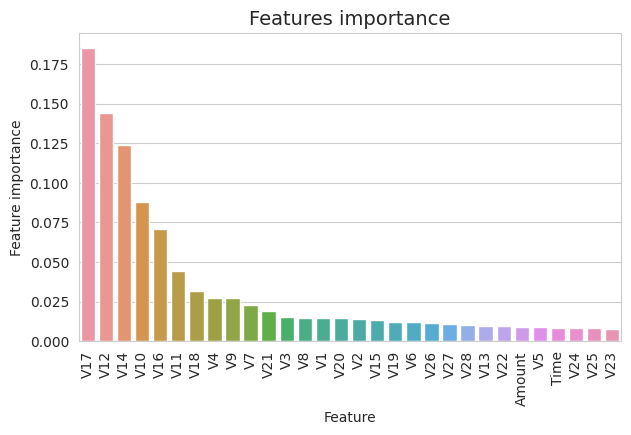

In [97]:
# Visualize the features importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are V17, V12, V14, V10, V16

Potentially remove 'V3','V8','V1','V20','V2','V15','V19','V6','V26','V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'

Attempt 2 with a lower cut off point. Remove 'V19','V6','V26','V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'

The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes. An AUC score of 1 means the classifier can perfectly distinguish between all the Positive and the Negative class points

In [98]:
#Let's calculate the ROC-AUC score
roc_auc_score(y_val.values, y_pred)

0.9031906379063597

In [99]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[56865,     4],
       [   18,    75]])

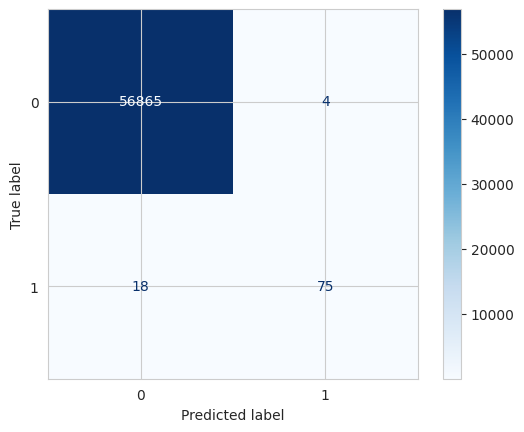

In [100]:
#count of true negatives is {0,0}, false negatives is {1,0}, true positives is {1,1} and false positives is {0,1}
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [101]:
print('accuracy is',accuracy_score(y_pred,y_val))

accuracy is 0.9996137776061234


In [102]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.95      0.81      0.87        93

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



## 5.1 Basic RFC Results

ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1



## Remove Unimportant Features

Let's see if the model performs as well if we remove the features that have least importance


In [25]:
reduced_df = df.drop(['V3','V8','V1','V20','V2','V15','V19','V6','V26',
                    'V27','V28','V13','V22','Amount','V5','Time','V24','V25','V23'], axis=1)



In [28]:
start = timer()

# Build data sets
X_train, y_train, X_val, y_val, X_test, y_test = build_test_datasets(reduced_df)

# Initialise the model
reduced_clf = clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)

# Train the RandomForestClassifier using the training data and fit function
reduced_clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = reduced_clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[56865     4]
 [   18    75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.95      0.81      0.87        93

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

time taken: 193.74336068699995


Completed in 60% of the time. Small loss of performance with 1 correct prediction now showing as an additional false negative. Can live with that??

## 5.2 With Cross Validation

In [ ]:
X = reduced_df.drop('Class', axis=1)
y = reduced_df['Class']

# Just split the df into train and test as we are doing cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state, shuffle=True )


In [ ]:
# Initialise the model
reduced_clf = clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)

results = cross_val_score(reduced_clf, X_train, y_train, cv=5, scoring='recall')
print(results)
print('mean recall result:', np.mean(results))

[0.81578947 0.81818182 0.84415584 0.77922078 0.71428571]
mean recall result: 0.7943267259056732


0.7940620782726046

# 6. Dealing with An Imbalanced Dataset

 Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud.

Will go back to the original full dataframe as there may be features whose importance was hidden in the unbalanced dataset

## Scaling 

In [123]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)


# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop old columns
df.drop(['Time','Amount'], axis=1, inplace=True)

# Move new scaled columns to start of df
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 6.1 Oversampling - stratified

The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [107]:

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [109]:
len(original_Xtest)+len(original_Xtrain)

284807

In [124]:
# Use undersampling to create a dataset with a 50/50 split of fraud vs non fraud cases

# shuffle the df
df = df.sample(frac=1, random_state=random_state)

fraud_df = df.loc[df['Class'] == 1]
genuine_df = df.loc[df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, genuine_df])

# Shuffle the new df
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
244310,0.656746,0.794253,2.096891,-1.188574,-1.080026,-1.198440,-0.401766,0.525172,-1.049297,0.103533,...,0.195181,0.338792,0.898077,-0.030712,-0.295096,-0.019401,-0.082635,-0.006634,-0.050797,0
14197,1.089779,-0.698563,-16.598665,10.541751,-19.818982,6.017295,-13.025901,-4.128779,-14.118865,11.161144,...,1.534920,1.725853,-1.151606,-0.680052,0.108176,1.066878,-0.233720,1.707521,0.511423,1
29717,3.451408,-0.576757,0.902297,-1.561827,-0.639501,-2.517028,-1.269761,-1.561292,0.257347,-0.386042,...,-0.079996,-0.470025,-1.364787,-0.051960,0.343052,0.322216,-1.058844,0.020648,0.064997,0
176049,29.398030,0.445447,-2.003460,-7.159042,-4.050976,1.309580,-2.058102,-0.098621,2.880083,-0.727484,...,3.973217,1.244287,-1.015232,-1.800985,0.657586,-0.435617,-0.894509,-0.397557,0.314262,1
178208,0.328513,0.456220,-5.904921,4.439911,-8.631802,7.788684,-4.989580,-1.200144,-7.674060,4.125761,...,-0.505608,1.775030,1.266441,-0.199410,0.014960,-0.000019,0.544210,-1.167566,-1.206354,1


In [125]:
print(new_df.shape)
# check ratio of fraud vs genunie class counts
print(new_df['Class'].value_counts()/len(new_df))

(984, 31)
0    0.5
1    0.5
Name: Class, dtype: float64


Let's look again at which features influence whether a specific transaction is a fraud but using the new balanced dataset

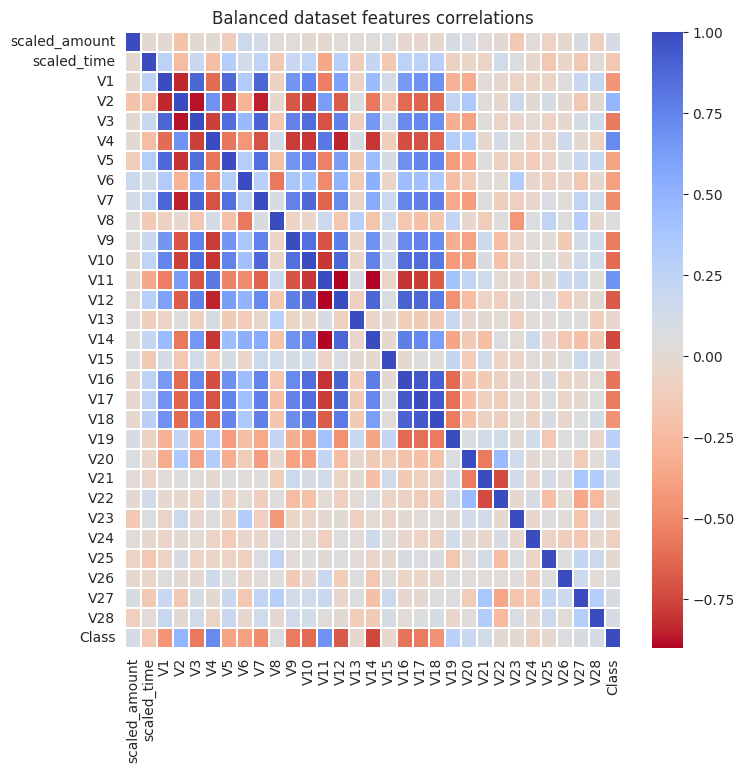

In [126]:
# Use a heatmap to show the correlation between the input variables
plt.figure(figsize = (8,8))
plt.title('Balanced dataset features correlations')
corr = new_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="coolwarm_r")
plt.show()
plt.close()

Very different pattern and a lot more correlation than shown with the unbalanced original dataset

V17, V14, V12 and V10 are most heavily negatively correlated. The lower values indicate higher likelihood to be a fraud.

Can use box plots to show the distribution:

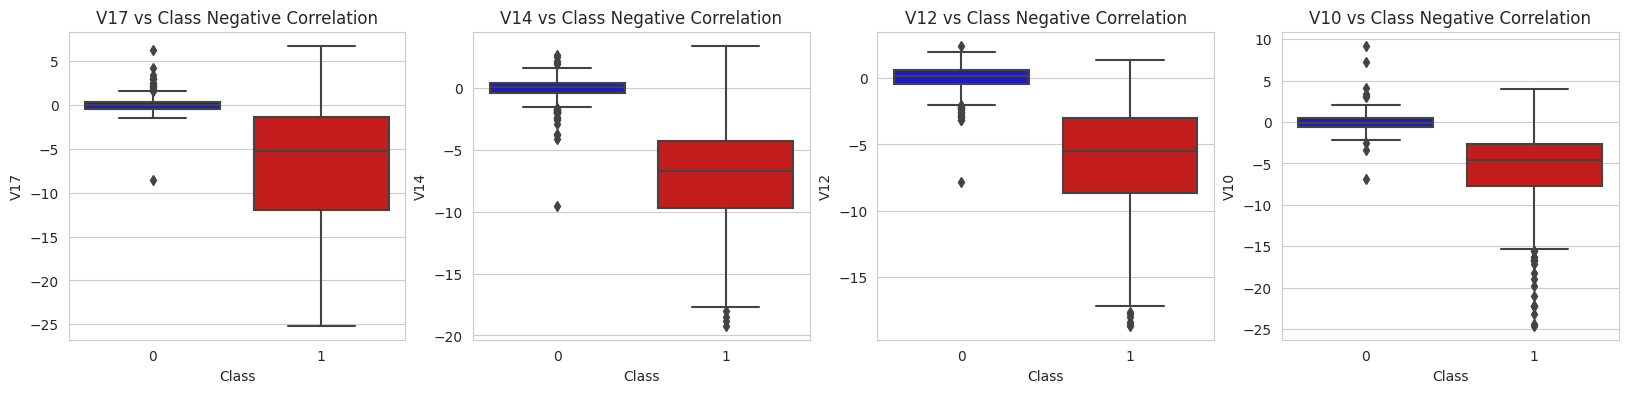

In [127]:
colors = ["#0101DF", "#DF0101"]

f, axes = plt.subplots(ncols=4, figsize=(20,4))


sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

V2, V4, V11, and V19 are most heavily positively correlated. The higher values indicate lower liklihood to be fraud

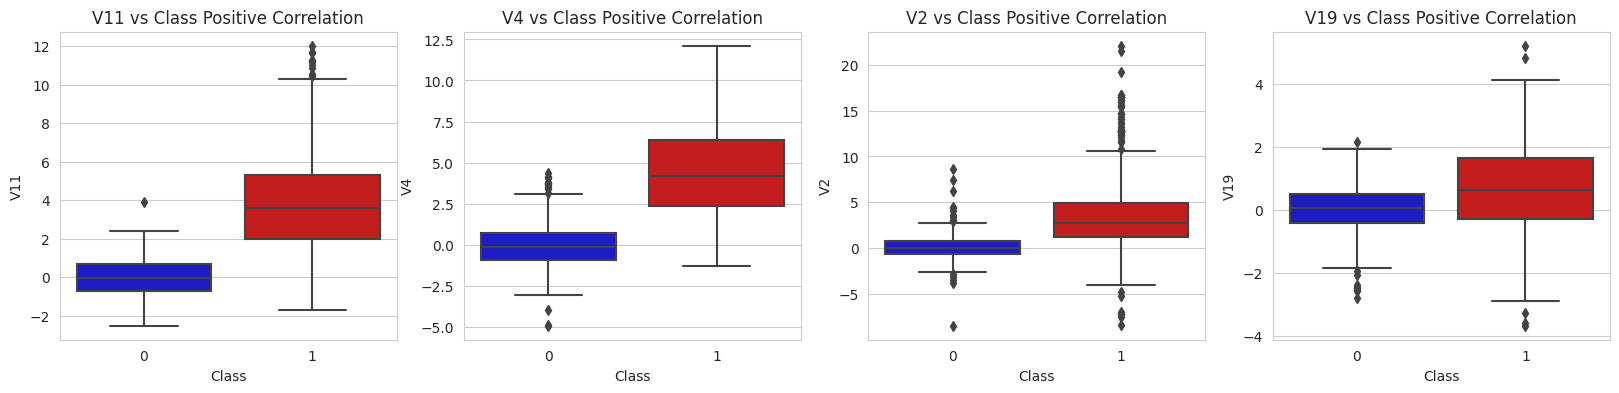

In [128]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## 6.2 Detect & Remove Outliers

Focusing on removing outliers from those features that heavily influence the unbalanced fraud output class can help improve the model performance.

Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect

In [129]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.0499976898594, -18.4937733551053, -18.8220867423816, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.4311310279993, -18.6837146333443, -18.0475965708216]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-16.3035376590131, -16.649628

In [130]:
start = timer()

# Build data sets
X_train, y_train, X_val, y_val = build_datasets(new_df)

# Initialise the model
clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[87  3]
 [ 9 91]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        90
           1       0.97      0.91      0.94       100

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190

time taken: 0.39898585499759065


In [139]:


ros = RandomOverSampler(random_state=random_state)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [140]:
X = df.drop('Class', axis=1)
y = df['Class']

X_resampled, y_resampled = ros.fit_resample(X, y)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(284807, 30)
(284807,)
(568630, 30)
(568630,)


In [141]:
print(df['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [143]:
print(y_resampled.value_counts())

0    284315
1    284315
Name: Class, dtype: int64


In [147]:
# Get a test dataset first that isn't part of the oversampling
X_train, y_train, X_test, y_test = build_datasets(df)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state, shuffle=True )


(284807, 30)
(284807,)
(454922, 30)
(454922,)


In [148]:

# Initialise the model
clf = initialise_rfc(num_estimators=100, max_features=5, max_depth=None)

# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

end = timer()
print('time taken:', end - start)

[[45441     7]
 [    0 45537]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45448
           1       1.00      1.00      1.00     45537

    accuracy                           1.00     90985
   macro avg       1.00      1.00      1.00     90985
weighted avg       1.00      1.00      1.00     90985

time taken: 3295.2216292589983


In [149]:
# Now predict the target values for the test data (that hasn't been oversampled) and show results
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[56847     7]
 [   24    84]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56854
           1       0.92      0.78      0.84       108

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# test on untrained / unsampled data
# so seperate out a test set before doing the oversampling

# validation good results but shows overfitting when then testing on test data?

# TUESDAY
# Build against new_df with enhancements then test on the original

# compare oversampling with undersampling


# compare results

#

# 7. Hyperparameter Tuning